# First, set up some vars

In [7]:
# Set style
TEX_PARAMS = {
    "text.usetex": False,  # use LaTeX to write all text
    "pgf.rcfonts": False,  # Ignore Matplotlibrc
    "pgf.texsystem": "lualatex",  # hoping to avoid memory issues
}

In [8]:
# Set the random seed for reproducibility
RANDOM_SEED = 60

# Step 0. Read the raw data

In [9]:
import pathlib
import pandas as pd
import numpy as np
import os

In [10]:
# Set the folders needed
output_folder = pathlib.Path('./output/')
data_folder = pathlib.Path('./data/')
processed_folder = data_folder.joinpath('processed')
raw_data_folder = data_folder.joinpath('raw_data')

# Create all the subfolders to store the output files
if not output_folder.exists():
    os.mkdir(output_folder)
    os.mkdir(output_folder.joinpath('img'))
    os.mkdir(output_folder.joinpath('deployments'))
    os.mkdir(output_folder.joinpath('models'))
    os.mkdir(output_folder.joinpath('clusters'))

In [11]:
# Read the processed data
df = pd.read_pickle(processed_folder.joinpath('df_complete.pkl'))
freqticks = np.load(processed_folder.joinpath('used_freqticks.npy'))
df_features_complete = df.iloc[:, :len(freqticks)]

print('Total amount of samples: ', len(df))

print('existing columns: ', df.columns)
print('frequency columns: ', df_features_complete.columns)

Total amount of samples:  7116
existing columns:  Index([                0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8,
                       9,                10,                11,
                      12,                13,                14,
                      15,                16,                17,
                      18,                19,   'route_density',
                'season',      'moon_phase',      'day_moment',
         'sediment_type',      'bathymetry',            'tide',
       'deployment_name',        'datetime',        'geometry',
                      20,                21],
      dtype='object')
frequency columns:  Index([              0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,              10,              1

In [12]:
# THESE VARS SHOULD MATCH THE ONES YOU DEFINED IN 2_prepare_data
ENV_LABELS = [
    'route_density',
    'season',
    'moon_phase',
    'day_moment',
    'sediment_type',
    'bathymetry',
]


ARTIFACTS_LABELS = ['clipping', 'rope_noise']

CATEGORICAL_VARS = ['day_moment', 'sediment_type', 'seabed_habitat', 'label']

CYCLIC_VARS = ['moon_phase', 'season']

## Clustering

The clustering is done using the DBSCAN algorithm (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).
This algorithm creates a "noise" class from all the samples that can not be assigned to a certain cluster. This class is represented by a -1.

# Acoustic categorization
## Dimension reduction

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import umap

Dimension reduction... Some patience needed...


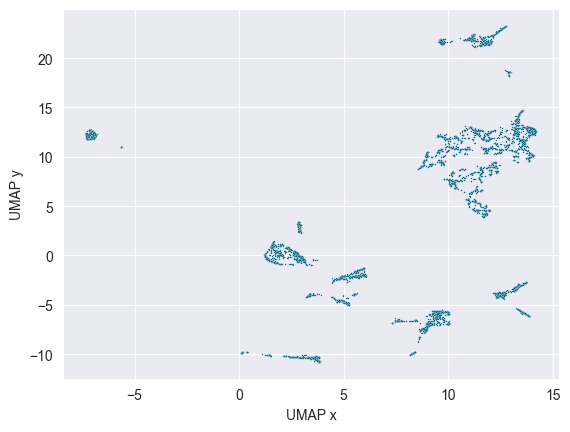

In [14]:
print('Dimension reduction... Some patience needed...')
umap_mapper = umap.UMAP(n_neighbors=50, min_dist=0.0, n_components=2, random_state=RANDOM_SEED).fit(df_features_complete.values)
x_umap = umap_mapper.transform(df_features_complete.values)
df_umap = pd.DataFrame(x_umap)
df_umap.to_pickle(data_folder.joinpath('processed/umap_clean.pkl'))

# Create the figure of the final UMAP distribution on clean data
sns.scatterplot(x=df_umap.values[:, 0], y=df_umap.values[:, 1], color='#006582ff', s=1)
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.savefig(output_folder.joinpath('img/umap_projection_clean_data.png'), dpi=350, transparent=True)
plt.show()

## Clustering

C:\Users\cleap\Envs\wadden_soundscape\lib\site-packages\seaborn\_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


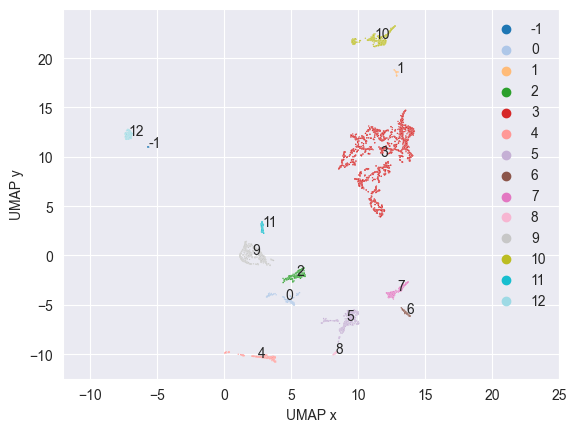

In [15]:
# Get the clusters
predicted_clusters = DBSCAN(min_samples=50, eps=0.9).fit_predict(df_umap)

# Save the clusters with the umap
df_umap_with_clusters = df_umap.assign(clusters=predicted_clusters)
df_umap_with_clusters.clusters = df_umap_with_clusters.clusters.astype('category')
df_umap_with_clusters.to_pickle(data_folder.joinpath('processed/umap_clean_with_clusters.pkl'))


# Add them to the df
df_clean = df.assign(clusters=predicted_clusters)
df_clean.clusters = df_clean.clusters.astype('category')

# From now on, this will be the cmap used everywhere for consistency with the cluster colors!
unique_clusters = df_clean['clusters'].dtype.categories.values
cmap = plt.get_cmap('tab20', len(unique_clusters))
hue_order = np.arange(predicted_clusters.min(), predicted_clusters.max() + 1).astype(str)

# Plot the UMAP dimension with the final clusters
sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=predicted_clusters.astype(str), hue_order=hue_order, s=1, palette=cmap.colors)
for cluster in np.unique(predicted_clusters):
        mask = predicted_clusters == cluster
        x_mean, y_mean = df_umap.loc[mask].mean()
        plt.text(x_mean, y_mean, cluster)
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.xlim(-12, 25)
plt.legend(fancybox=True, framealpha=0.0)
plt.savefig(output_folder.joinpath('img/DBSCAN_clusters.png'), dpi=350, transparent=True)
plt.show()


# Explain the unexplained soundscapes. Acoustic and environmental characterization
## Prepare the data the right way

In [16]:
# Remove the noise clusters
unique_clusters = df_clean['clusters'].dtype.categories.values
cmap = plt.get_cmap('tab20', len(unique_clusters))
noise_samples = predicted_clusters == -1
print('Total of noise samples', noise_samples.sum() / len(predicted_clusters))

# Remove the noise clusters
df_rf = df_clean.loc[~noise_samples]
df_umap_rf = df_umap.loc[~noise_samples]

# Get the percentage of samples per cluster
print(df_clean.value_counts(subset=['clusters'], sort=False) * 100 / len(df))

# Prepare the data for the RF
x = df_rf[ENV_LABELS + ['clusters']].copy()
x['clusters'] = x['clusters'].astype(str)

for cy_var in CYCLIC_VARS:
    if cy_var == 'season':
        # Convert the week number into a degree
        x[cy_var] = x[cy_var] / 52 * 2 * np.pi
    x[cy_var + '_sin'] = np.sin(x[cy_var])
    x[cy_var + '_cos'] = np.cos(x[cy_var])
    x = x.drop([cy_var], axis=1)

for c in x.columns:
    if c in CATEGORICAL_VARS:
        x[c] = x[c].astype(str)

x.rename(columns={'moon_phase_sin': 'growing_moon', 'moon_phase_cos': 'new_moon',
                  'season_sin': 'week_n_sin', 'season_cos': 'week_n_cos'},
         inplace=True)

Total of noise samples 0.006323777403035413
clusters
-1           0.632378
0            4.328274
1            0.829117
2            5.578977
3           39.165261
4            6.084879
5            9.387296
6            2.388983
7            5.241709
8            1.714446
9            8.923553
10           9.682406
11           2.459247
12           3.583474
Name: count, dtype: float64


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import shap
import os

from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold, GridSearchCV

from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)

from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerSelector, ParameterSpace

from shap._explanation import group_features

from matplotlib.colors import ListedColormap

In the future `np.bool` will be defined as the corresponding NumPy scalar.


First we will check if any of the variables are clearly redundant (not when used by the model but just by themselves) using the Boruta algorithm.
Then, we will analyze the model with all the data. This will be run several times, because after each model we want to analyze if there are any of the independent variables (environmental variables) which are redundant.

In [18]:
def get_redundant_pair(inspector, n_clusters, exclude_vars):
    redundancy_total = None
    for class_i, class_str in enumerate(inspector.output_names):
        # Get redundancy of class i
        redundancy_matrix = inspector.feature_redundancy_matrix(clustered=False)[class_i]

        if redundancy_total is None:
            redundancy_total = (redundancy_matrix.values > 0.50).astype(int)
        else:
            redundancy_total = redundancy_total + (redundancy_matrix.values > 0.50).astype(int)

    for n in range(len(redundancy_total)):
        redundancy_total[n, n] = 0

    for var in exclude_vars:

        redundancy_total[np.where(redundancy_matrix.names[0] == var)[0][0], :] = 0
        redundancy_total[:, np.where(redundancy_matrix.names[1] == var)[0][0]] = 0

    if redundancy_total.max().max() < (n_clusters / 3):
        return None
    else:
        max_redundant = pd.DataFrame(redundancy_total, index=redundancy_matrix.names[0], columns=redundancy_matrix.names[1]).agg(['idxmax', 'max'], axis=1).astype({'max': int}).nlargest(1, 'max')
        return max_redundant.iloc[0].name, max_redundant.iloc[0]['idxmax']

In [19]:
# Get redundant pair
def plot_shap_results(save_path_iteration, shap_data, inspector, n_clusters, feature_map):
    grouped_explanation_values = []
    grouped_explanation_data = []
    for class_i, class_str in enumerate(inspector.output_names):
        # Create an explanation for the class i
        explanation_i = shap.Explanation(shap_data.shap_values[class_i],
                                         data=shap_data.features.values,
                                         feature_names=list(shap_data.features.columns)
                                         )

        # Join the one hot encoded variables for a better understanding of the plot (not used for redundancy)
        grouped_explanation = group_features(explanation_i, feature_map=feature_map)
        for feature_i, encoded_feature in enumerate(grouped_explanation.feature_names):
            if encoded_feature in CATEGORICAL_VARS:
                grouped_explanation.data[:, feature_i] = np.nan
        grouped_explanation_values.append(grouped_explanation.values)
        grouped_explanation_data.append(grouped_explanation.data)

        # standard SHAP summary plot using the shap package
        shap.plots.beeswarm(grouped_explanation, show=False, max_display=None)
        plt.title('Class %s' % class_str)
        plt.savefig(save_path_iteration.joinpath('class_%s_summary_grouped.png' % class_str), transparent=True, dpi=350,
                    bbox_inches="tight")
        plt.show()

        shap.plots.beeswarm(explanation_i, show=False, max_display=None)
        plt.title('Class %s' % class_str)
        plt.savefig(save_path_iteration.joinpath('class_%s_summary.png' % class_str), transparent=True, dpi=350,
                    bbox_inches="tight")
        plt.show()

    # standard total SHAP summary plot using the shap package
    # Change the cmap so it matches the rest of the plots (first color reserved for -1 cluster)
    cmap_colors = plt.get_cmap('tab20', n_clusters + 1).colors[1:, :]
    cmap = ListedColormap(cmap_colors, 'clusters')
    explanation_global = shap.Explanation(grouped_explanation_values,
                                          data=grouped_explanation_data,
                                          feature_names=grouped_explanation.feature_names
                                          )
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values=explanation_global, show=False, color=cmap,
                      class_inds=np.arange(n_clusters-1), plot_size=(12, 8))
    plt.savefig(save_path_iteration.joinpath('summary_features.png'), transparent=True, dpi=350,
                bbox_inches="tight")
    plt.show()

In [ ]:
model_path = output_folder.joinpath('models')
clusters_path = output_folder.joinpath('clusters')

# Do a Random Search to find the best hyperparameters
class_weights = None

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_SEED)

cat_features = []
for c in x.columns:
    if c in CATEGORICAL_VARS:
        cat_features.append(c)

print('These are the categorical features', cat_features)
onehot_enc = OneHotEncoderDF(handle_unknown='error', sparse_output=False).fit(x[cat_features])
x_encoded = onehot_enc.transform(x[cat_features])
x_numerical = x.drop(columns=cat_features)

samples = Sample(observations=x_numerical.join(x_encoded), target_name='clusters')

# put the pipeline together
preprocessing_numerical = SimpleImputerDF(strategy='median')
preprocessing_features = ColumnTransformerDF(
    transformers=[
        (
            'numerical',
            preprocessing_numerical,
            make_column_selector(dtype_include=np.number),
        ),
    ]
)
boruta_feature_selection = PipelineDF(
    steps=[
        ('preprocessing', preprocessing_features),
        (
            'boruta',
            BorutaDF(
                estimator=RandomForestClassifierDF(
                    max_depth=10, n_jobs=-3, random_state=RANDOM_SEED, min_samples_split=300,
                    min_samples_leaf=200, max_leaf_nodes=10
                ),
                n_estimators='auto',
                random_state=RANDOM_SEED,
                verbose=False,
            ),
        ),
    ]
)

# Start all the variables before the loop
all_redundant_vars_are_out = False
variables_to_not_remove = []
features_to_ignore = []
iteration_n = 0
performance = 0
best_model = None
results_iterations = pd.DataFrame(columns=['iteration_n', 'mean_acu', 'st_acu', 'removed_features_boruta',
                                           'removed_features_redundant', 'max_redundant_pair'])
while not all_redundant_vars_are_out:
    model_path_iteration = model_path.joinpath('iteration_%s' % iteration_n)
    if not model_path_iteration.exists():
        os.mkdir(model_path_iteration)

    # Run feature selection using Boruta and report those selected
    samples_i = samples.drop(feature_names=features_to_ignore)
    boruta_feature_selection.fit(X=samples_i.features, y=samples_i.target)
    selected = boruta_feature_selection.feature_names_original_.unique()
    not_selected = list(set(samples_i.feature_names) - set(selected))

    print('Vars that were already removed from the iteration', features_to_ignore)
    # print('Boruta removed vars', not_selected)
    # samples_i = samples_i.keep(feature_names=selected)

    random_search_path = model_path_iteration.joinpath('random_search.joblib')
    if not random_search_path.exists():
        clf = RandomForestClassifierDF(class_weight=class_weights, random_state=RANDOM_SEED, n_estimators=10)

        clf_pipeline = ClassifierPipelineDF(classifier=clf)
        clf_grid = ParameterSpace(clf_pipeline, name='random forest')
        clf_grid.classifier.criterion = ['gini', 'entropy']
        clf_grid.classifier.min_samples_split = [100, 300, 500]
        clf_grid.classifier.max_depth = [6, 8, 12]
        clf_grid.classifier.min_samples_leaf = [100, 200, 300]
        clf_grid.classifier.max_leaf_nodes = [10, 15, 20]

        model_ranker = LearnerSelector(searcher_type=GridSearchCV, parameter_space=clf_grid, cv=cv, n_jobs=None).fit(sample=samples_i)
        joblib.dump(model_ranker, random_search_path)
    else:
        model_ranker = joblib.load(random_search_path)

    # Print the results of the model in a csv, with all the explored grid
    cv_results = model_ranker.summary_report()
    cv_results.to_csv(model_path_iteration.joinpath('cv_results.csv'))
    n_clusters = len(x.clusters.unique())

    print('Performance of the model')
    print('Mean accuracy', cv_results.loc[0]['score']['test']['mean'])
    print('Mean std', cv_results.loc[0]['score']['test']['std'])

    # Check if the model decreased performance by more than 1%
    if cv_results.loc[0]['score']['test']['mean'] < (performance - 0.01):
        # discard this model
        last_discarded_var = features_to_ignore.pop()
        variables_to_not_remove.append(last_discarded_var)
        print('Performance decreased. Feature %s discarded' % last_discarded_var)
    else:
        final_best_model = model_ranker.best_estimator_
        final_samples = samples_i
        performance = cv_results.loc[0]['score']['test']['mean']
        print('Getting the explainer...')
        explainer_path = model_path_iteration.joinpath('explainer_interventional.joblib')
        shap_values_path = model_path_iteration.joinpath('shap_values.joblib')
        if not explainer_path.exists():
            inspector = LearnerInspector(final_best_model, n_jobs=-3, verbose=True)
            inspector.fit(samples_i)
            joblib.dump(inspector, explainer_path)
        else:
            inspector = joblib.load(explainer_path)

        if not shap_values_path.exists():
            # get some info for standard SHAP model inspection
            shap_data = inspector.shap_plot_data()
            joblib.dump(shap_data, shap_values_path)
        else:
            shap_data = joblib.load(shap_values_path)

        feature_map = {}
        for encoded_col in shap_data.features.columns:
            stem = '_'.join(encoded_col.split('_')[:-1])
            if stem in cat_features:
                feature_map[encoded_col] = stem

        redundant_pair = get_redundant_pair(inspector=inspector, n_clusters=n_clusters, exclude_vars=variables_to_not_remove)

        if redundant_pair is not None:
            features_to_ignore.append(redundant_pair[0])
            redundant_pair_str = ','.join(redundant_pair)
        else:
            all_redundant_vars_are_out = True
            redundant_pair_str = ''
            plot_shap_results(clusters_path, shap_data, inspector, n_clusters, feature_map)

    best_row = cv_results.loc[0]
    results_iterations.loc[len(results_iterations)] = [iteration_n, best_row['score']['test']['mean'],
                                                       best_row['score']['test']['std'], ','.join(not_selected),
                                                       ','.join(features_to_ignore), redundant_pair_str]
    results_iterations.to_csv(model_path.joinpath('iterations_evolution.csv'))

    iteration_n += 1

joblib.dump(final_best_model, model_path.joinpath('final_model.joblib'))
joblib.dump(final_samples, model_path.joinpath('final_samples.joblib'))

['day_moment', 'sediment_type']


the following attributes of BorutaDF have been replaced with their native scikit-learn counterparts: estimator


Vars that were already removed from the iteration []


# Performance analysis


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


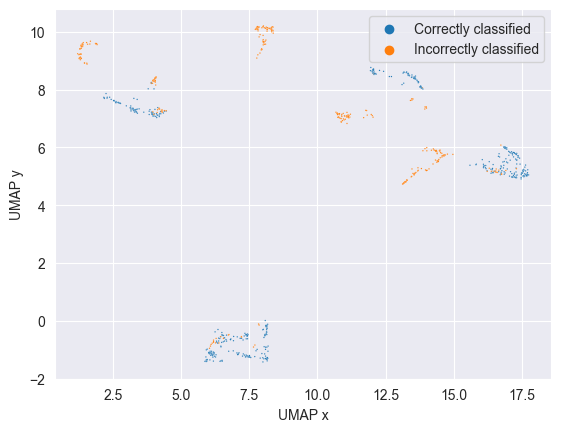

  cluster n_samples percentage_samples correctly_classified
0      -1         0                0.0                  NaN
1       0       181          19.255319             0.889503
2       1        82           8.723404             0.853659
3       2        52           5.531915                  0.0
4       3       144          15.319149             0.895833
5       4        84            8.93617                  0.0
6       5        63           6.702128                  0.0
7       6       118          12.553191             0.686441
8       7        56           5.957447                  0.0


invalid value encountered in scalar divide


In [16]:
# Predict the clusters
rf_clusters = final_best_model.classifier.predict(final_samples.features)
df_rf['rf_prediction'] = rf_clusters.astype(int)

# Check which ones are correct
correct_explanation = df_rf['rf_prediction'].astype(str) == df_rf['clusters'].astype(str)
correct_explanation = correct_explanation.replace(False, 'Incorrectly classified')
correct_explanation = correct_explanation.replace(True, 'Correctly classified')

# Plot the correct/incorrect classifications in UMAP
sns.scatterplot(x=df_umap_rf[0].values, y=df_umap_rf[1].values, s=1, hue=correct_explanation)
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.savefig(output_folder.joinpath('img/correct_explanation.png'), dpi=350, bbox_inches="tight",
            transparent=True)
plt.show()

# Count of many samples per cluster were wrongly explained
clusters_explanation = pd.DataFrame(columns=['cluster', 'n_samples',
                                             'percentage_samples', 'correctly_classified'])
i = 0
for cluster_n, cluster_samples in df_rf.groupby('clusters'):
    percentage_classified = (cluster_samples.clusters.astype(str) ==
                             cluster_samples.rf_prediction.astype(str)).sum() / len(cluster_samples)
    clusters_explanation.loc[i, :] = cluster_n, len(cluster_samples), len(cluster_samples)/len(df) * 100, percentage_classified
    i += 1

print(clusters_explanation)

In [17]:
# Add the prediction and the clusters to the total dataset (also with the -1 class)
df_clean['clusters'] = -1
df_clean['rf_prediction'] = -1
df_clean.loc[df_rf.index, ['clusters', 'rf_prediction']] = df_rf[['clusters', 'rf_prediction']].values
df_clean['clusters'] = df_clean['clusters'].astype('category')
df_clean['rf_prediction'] = df_clean['rf_prediction'].astype('category')

## Temporal - spatial analysis

In [18]:
import datetime
import xarray
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

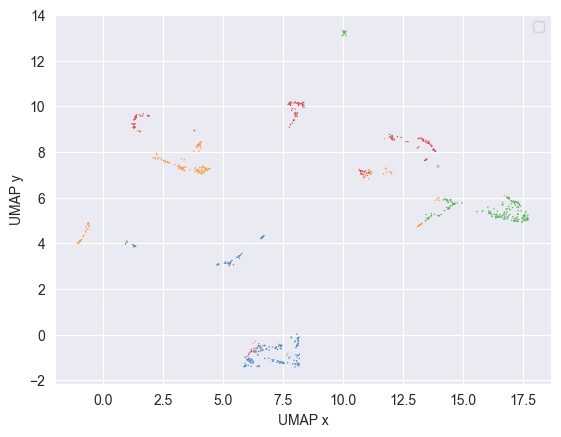

In [19]:
# Plot the distribution depending on the deployment id to make sure not all the clusters are one individual cluster
sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=df_clean['deployment_name'].astype(str), s=1)
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.legend('')
plt.show()

We can see that some clusters are unique deployments, but not all of them. It makes sense that one deployment of 1 h in a single location has similar sounds, so the fact that the samples of each deployment are close by is a good sign. However, if we would not have mixing clusters, the clustering method would not make a lot of sense.

### Let's make some spatial plots to see how our clusters are distributed!

First we need to load some background information to make more sense of the deployments

In [20]:
# Get the metadata
metadata = pd.read_csv(raw_data_folder.joinpath('data_summary_mda.csv'))

In [21]:
# Define a plotting function to plot the deployment temporally
def plot_temporal_evolution(deployment_path, deployment_name, df_complete, secondary_axis, secondary_axis_label, save_folder):
    # Get the original 1-sec resolution
    deployment = xarray.open_dataset(raw_data_folder.joinpath('deployments/deployments', deployment_path))
    deployment = deployment.sortby('datetime')
    print(df_complete)
    deployment_mask = df_complete.loc[df_complete.deployment_name == deployment_name].index

    df_deployment = df_complete.loc[deployment_mask][['clusters', 'datetime', 'rf_prediction', secondary_axis]]
    df_deployment = df_deployment.set_index('datetime')
    ds_deployment = df_deployment.to_xarray()

    ds_deployment = ds_deployment.sortby('datetime')
    ds_deployment.reindex({'datetime': deployment.datetime.values},
                          tolerance=datetime.timedelta(seconds=1), method='nearest')
    ds_deployment['clusters'] = ds_deployment['clusters'].expand_dims({'id': [0, 1]})
    ds_deployment['rf_prediction'] = ds_deployment['rf_prediction'].expand_dims({'id': [0, 1]})
    ds_deployment = ds_deployment.fillna(-1)
    ds_deployment['rf_prediction'] = ds_deployment['rf_prediction'].astype(int)

    # plots with spectra
    # Get the clusters present for the legend
    clusters_present_real = np.array(df_deployment['clusters'].unique()) + 1
    clusters_present_predicted = np.array(df_deployment['rf_prediction'].unique()) + 1
    clusters_present = np.unique(np.concatenate([clusters_present_real, clusters_present_predicted]))
    clusters_present.sort()

    fig, [ax, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 4), sharex=True,
                                       gridspec_kw={'height_ratios': [1, 1, 2.5]})
    ds_deployment['clusters'].plot.pcolormesh(cmap=cmap, vmin=unique_clusters.min(), vmax=unique_clusters.max(),
                                              add_colorbar=False, ax=ax)
    ax.yaxis.set_visible(False)
    ax.set_xlabel('')
    ax.set_title('Acoustic categories')
    ds_deployment['rf_prediction'].plot.pcolormesh(cmap=cmap, vmin=unique_clusters.min(),
                                                   vmax=unique_clusters.max(),
                                                   add_colorbar=False, ax=ax2)
    ax2.yaxis.set_visible(False)
    ax2.set_xlabel('')
    ax2.set_title('Predicted categories RF')

    ax_1 = ax.twinx()
    ds_deployment[secondary_axis].plot(ax=ax_1, color='k')
    ax_1.set_ylabel(secondary_axis_label)

    deployment['oct3'].T.plot.pcolormesh(add_colorbar=False, ax=ax3, yscale='symlog',
                                         x='datetime', y='frequency', cmap='Greys')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax3.set_xlabel('Time of the day (%s)' % deployment.datetime.dt.date.isel(id=0).values)
    ax3.set_ylabel('Frequency [Hz]')

    handles = []
    for cl in clusters_present:
        cl_patch = mpatches.Patch(color=cmap.colors[cl], label=str(cl-1))
        handles.append(cl_patch)
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.05, 0.75), title='Categories')
    fig.tight_layout()
    plt.savefig(deployments_folder.joinpath('deployment_%s_spectra_%s.png' % (deployment_name, secondary_axis)),
                transparent=True, dpi=350, bbox_inches="tight")
    plt.show()

We will first plot the original acoustic categories, the predicted categories and some environmental variables in the time domain, together with the third-octave bands. 

           0        1        2        3        4        5        6        7   
0    83.2500  88.9375  82.9375  81.3125  81.3750  79.3750  73.6875  75.4375  \
1    83.2500  88.8750  83.3125  81.4375  81.3750  79.4375  73.8125  75.6875   
2    82.9375  88.9375  83.5625  81.3125  81.1875  79.5625  73.8125  75.6250   
3    83.3750  88.8750  83.2500  81.1250  80.9375  79.1875  73.5000  75.1250   
4    83.3750  89.1250  83.1250  81.5625  81.6875  79.6875  73.5625  75.4375   
..       ...      ...      ...      ...      ...      ...      ...      ...   
935  81.0625  80.5625  80.2500  78.1875  77.7500  74.7500  72.9375  71.3125   
936  81.3125  80.4375  80.0625  78.0000  77.6250  74.6875  72.6875  71.1250   
937  79.8125  79.4375  80.0000  78.1250  78.4375  74.8750  72.6875  71.3125   
938  81.5625  83.5625  82.1875  80.0625  82.6250  79.1250  76.2500  77.0000   
939  82.5000  83.8125  82.2500  79.9375  82.3750  79.1250  76.3125  76.9375   

           8        9  ...  day_moment  sediment_ty

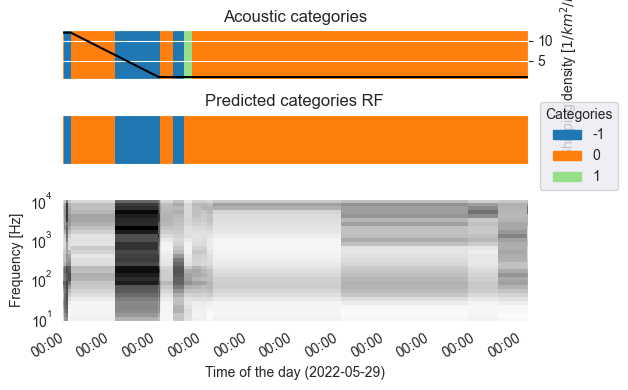

           0        1        2        3        4        5        6        7   
0    83.2500  88.9375  82.9375  81.3125  81.3750  79.3750  73.6875  75.4375  \
1    83.2500  88.8750  83.3125  81.4375  81.3750  79.4375  73.8125  75.6875   
2    82.9375  88.9375  83.5625  81.3125  81.1875  79.5625  73.8125  75.6250   
3    83.3750  88.8750  83.2500  81.1250  80.9375  79.1875  73.5000  75.1250   
4    83.3750  89.1250  83.1250  81.5625  81.6875  79.6875  73.5625  75.4375   
..       ...      ...      ...      ...      ...      ...      ...      ...   
935  81.0625  80.5625  80.2500  78.1875  77.7500  74.7500  72.9375  71.3125   
936  81.3125  80.4375  80.0625  78.0000  77.6250  74.6875  72.6875  71.1250   
937  79.8125  79.4375  80.0000  78.1250  78.4375  74.8750  72.6875  71.3125   
938  81.5625  83.5625  82.1875  80.0625  82.6250  79.1250  76.2500  77.0000   
939  82.5000  83.8125  82.2500  79.9375  82.3750  79.1250  76.3125  76.9375   

           8        9  ...  day_moment  sediment_ty

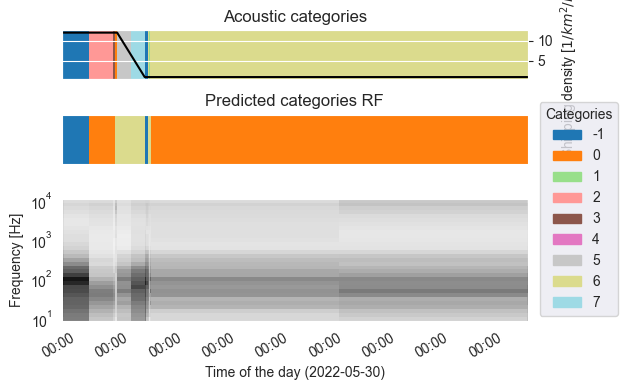

           0        1        2        3        4        5        6        7   
0    83.2500  88.9375  82.9375  81.3125  81.3750  79.3750  73.6875  75.4375  \
1    83.2500  88.8750  83.3125  81.4375  81.3750  79.4375  73.8125  75.6875   
2    82.9375  88.9375  83.5625  81.3125  81.1875  79.5625  73.8125  75.6250   
3    83.3750  88.8750  83.2500  81.1250  80.9375  79.1875  73.5000  75.1250   
4    83.3750  89.1250  83.1250  81.5625  81.6875  79.6875  73.5625  75.4375   
..       ...      ...      ...      ...      ...      ...      ...      ...   
935  81.0625  80.5625  80.2500  78.1875  77.7500  74.7500  72.9375  71.3125   
936  81.3125  80.4375  80.0625  78.0000  77.6250  74.6875  72.6875  71.1250   
937  79.8125  79.4375  80.0000  78.1250  78.4375  74.8750  72.6875  71.3125   
938  81.5625  83.5625  82.1875  80.0625  82.6250  79.1250  76.2500  77.0000   
939  82.5000  83.8125  82.2500  79.9375  82.3750  79.1250  76.3125  76.9375   

           8        9  ...  day_moment  sediment_ty

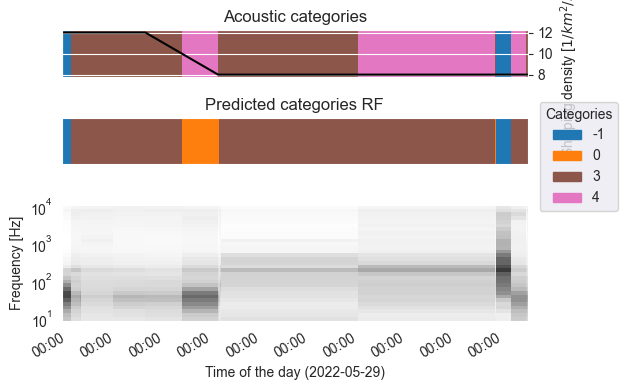

           0        1        2        3        4        5        6        7   
0    83.2500  88.9375  82.9375  81.3125  81.3750  79.3750  73.6875  75.4375  \
1    83.2500  88.8750  83.3125  81.4375  81.3750  79.4375  73.8125  75.6875   
2    82.9375  88.9375  83.5625  81.3125  81.1875  79.5625  73.8125  75.6250   
3    83.3750  88.8750  83.2500  81.1250  80.9375  79.1875  73.5000  75.1250   
4    83.3750  89.1250  83.1250  81.5625  81.6875  79.6875  73.5625  75.4375   
..       ...      ...      ...      ...      ...      ...      ...      ...   
935  81.0625  80.5625  80.2500  78.1875  77.7500  74.7500  72.9375  71.3125   
936  81.3125  80.4375  80.0625  78.0000  77.6250  74.6875  72.6875  71.1250   
937  79.8125  79.4375  80.0000  78.1250  78.4375  74.8750  72.6875  71.3125   
938  81.5625  83.5625  82.1875  80.0625  82.6250  79.1250  76.2500  77.0000   
939  82.5000  83.8125  82.2500  79.9375  82.3750  79.1250  76.3125  76.9375   

           8        9  ...  day_moment  sediment_ty

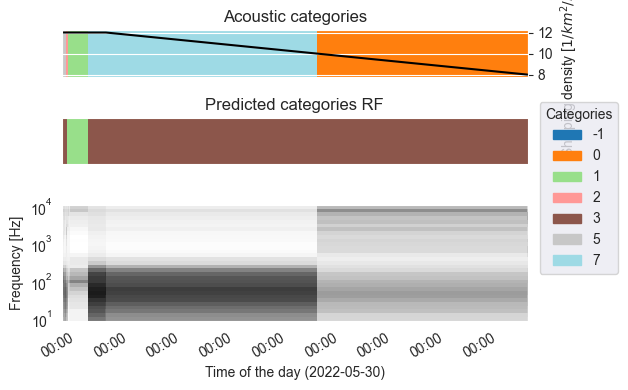

In [22]:
deployments_folder = output_folder.joinpath('deployments')
# Add more items in the dictionary if you want to plot other vars in time
vars_to_plot_in_time = {'route_density': r'Shipping density [$1/km^2/month$]'}
for i, row in metadata.iterrows():
    for var, sec_axis in vars_to_plot_in_time.items():
        plot_temporal_evolution(row.deployment_path, row.deployment_name, df_clean, secondary_axis=var, secondary_axis_label=sec_axis, save_folder=deployments_folder)


Now we will plot the same deployments in space with a significant background

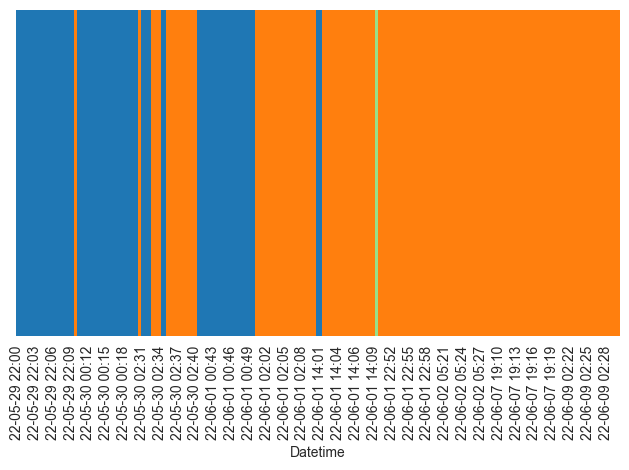

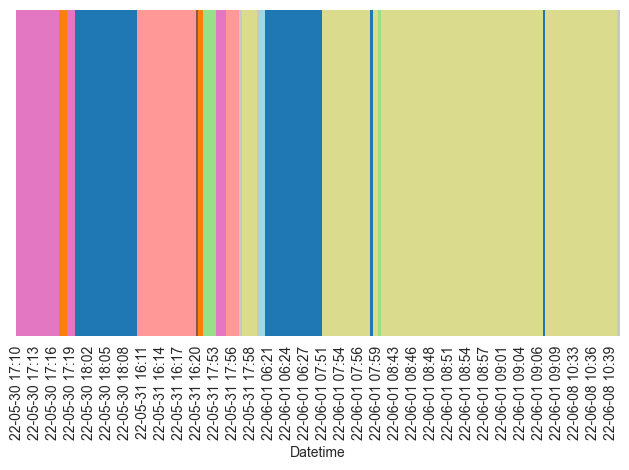

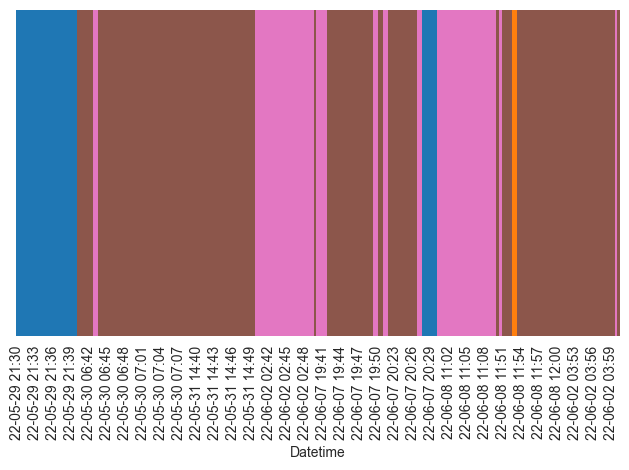

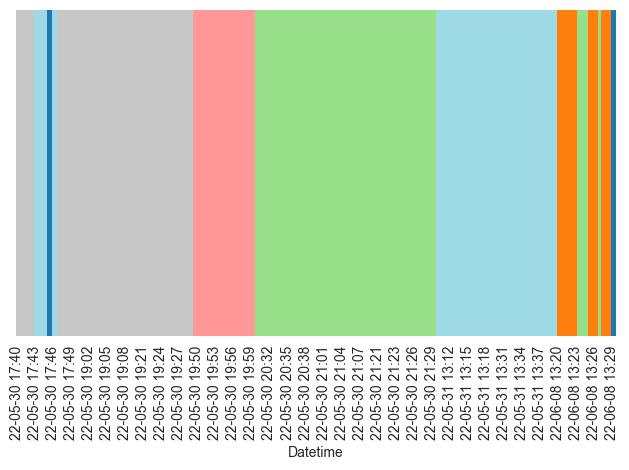

In [24]:
for deployment_name, deployment_df in df_clean.groupby('deployment_name'):
    df_clusters = pd.DataFrame(deployment_df[['clusters']].transpose().values.astype(int),
                               columns=deployment_df.datetime.round('min').dt.strftime(
                                   '%y-%m-%d %H:%M'))
    fig, ax = plt.subplots()
    sns.heatmap(data=df_clusters, cmap=cmap, cbar=False, ax=ax, vmin=unique_clusters.min(),
                vmax=unique_clusters.max())
    ax.yaxis.set_visible(False)
    plt.tight_layout()
    plt.xlabel('Datetime')
    plt.savefig(output_folder.joinpath('deployments/deployment_%s_temporal.png' % deployment_name), transparent=True)
    plt.show()

In [25]:
def force_plot_deployment(inspector, shap_data, base_values, final_samples, deployment_name, dfi, save_folder):
    mask = dfi.loc[dfi.deployment_name == deployment_name].index
    # Plot the evolution in time of the forces for
    deployment_mask_positions = np.arange(len(dfi))[dfi.deployment_name == deployment_name]
    three_dominant_clusters = dfi.loc[mask][['clusters']].value_counts(sort=True)[0:3]
    for dominant_cluster in three_dominant_clusters.index:
        if dominant_cluster[0] != -1:
            dominant_cluster = str(dominant_cluster[0])
            i = list(inspector.output_names).index(dominant_cluster)
            shap.plots.force(base_values[dominant_cluster],
                                           shap_values=shap_data.shap_values[i][deployment_mask_positions],
                                           features=final_samples.features.loc[mask])


In [26]:
shap.getjs()
shap.plots.initjs()
base_values = final_best_model.classifier.predict_proba(final_samples.features).mean(axis=0)
for deployment_name in df.deployment_name.unique():
    force_plot_deployment(inspector, shap_data, base_values, final_samples, deployment_name, df_rf, save_folder=deployments_folder)